# Двухуровневые модели рекомендаций

---

# Import libs

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
# from scipy.sparse import csr_matrix

# Матричная факторизация
# from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items, time_to_cat
from recommenders import MainRecommender

## Read data

In [3]:
data = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/retail_train.csv')
item_features = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/product.csv')
user_features = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/hh_demographic.csv')

# Process features dataset

In [5]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


### Features

- user_id - Уникально идентифицирует каждое домашнее хозяйство.
- basket_id - Uniquely identifies a purchase occasion. Однозначно идентифицирует случай покупки.
- day - Day when transaction occurred. День, когда произошла транзакция.
- item_id - Uniquely identifies each product. Уникально идентифицирует каждый продукт.
- quantity - Number of the products purchased during the trip. Количество продуктов, приобретенных во время визита в магазин.
- sales_value - Amount of dollars retailer receives from sale. Сумма долларов, которую ритейлер получает от продажи.
- store_id - Identifies unique stores. Однозначно идентифицирует магазины.
- retail_disc - Discount applied due to retailer's loyalty card program. Скидка, применяемая в связи с программой карты лояльности ритейлера.
- trans_time - Time of day when the transaction occurred. Время суток, когда произошла транзакция.
- week_no - Week of the transaction. Ranges 1 - 102. Неделя транзакции. Диапазон 1 - 102.
- coupon_disc - Discount applied due to manufacturer coupon. Скидка, применяемая в связи с купоном производителя.
- coupon_match_disc - Discount applied due to retailer's match of manufacturer coupon. Скидка применяется в связи с совпадением купона продавца с купоном производителя.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [7]:
data.isna().sum()

user_id              0
basket_id            0
day                  0
item_id              0
quantity             0
sales_value          0
store_id             0
retail_disc          0
trans_time           0
week_no              0
coupon_disc          0
coupon_match_disc    0
dtype: int64

### 1. Selection and construction of new features

#### Введём признак домохозяйства - в какое время дня чаще всего совершаются покупки, для этого расчетаем среднее время совершания покупок.

In [8]:
df_cat = data.groupby(['user_id'], as_index=False).mean()[['user_id','trans_time']]
df_cat = pd.DataFrame(df_cat)
df_cat.rename(columns={'trans_time': 'avr_trans_time'}, inplace=True)
df_cat['avr_trans_time'] = df_cat['avr_trans_time'].astype(int)
df_cat.head(2)

,user_id,avr_trans_time
0,1,1384
1,2,1805


In [9]:
data = data.merge(df_cat, on=['user_id'])
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237


In [10]:
data = time_to_cat(data)
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day


#### Создадим список покупок каждого домохозяйства

In [11]:
df_cat = data.groupby(['user_id'], as_index=False).agg({'basket_id': lambda x: set(x)})
df_cat.columns = ['user_id', 'list_basket_id']
df_cat.head(2)

,user_id,list_basket_id
0,1,"{32259826179, 28106322445, 31818756113, 325567..."
1,2,"{30035866883, 41008217091, 29157132423, 406185..."


#### Создадим признак - количество покупок каждого домохозяйства

In [12]:
df_cat['num_of_purchases'] = df_cat['list_basket_id'].apply(lambda x: len(x))
df_cat.drop('list_basket_id', axis=1,  inplace=True)
df_cat.head(2)

,user_id,num_of_purchases
0,1,79
1,2,44


In [13]:
data = data.merge(df_cat, on=['user_id'])
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day,105
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day,105


#### Создадим признак - кол-во недель, в какие совершались покупки

In [14]:
df_cat_1 = data.groupby(['user_id'], as_index=False)['week_no'].nunique()
df_cat_1.columns = ['user_id', 'num_week_no']
df_cat_1

,user_id,num_week_no
0,1,64
1,2,34
2,3,35
3,4,26
4,5,25
...,...,...
2494,2496,46
2495,2497,81
2496,2498,60
2497,2499,49


In [15]:
df_cat = data.groupby(['user_id'], as_index=False).agg({'week_no': lambda x: set(x)})
df_cat.columns = ['user_id', 'list_week_no']
df_cat['num_week_no'] = df_cat['list_week_no'].apply(lambda x: len(x))
df_cat.drop('list_week_no', axis=1,  inplace=True)
df_cat.head(2)

,user_id,num_week_no
0,1,64
1,2,34


In [16]:
data = data.merge(df_cat, on=['user_id'])
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day,105,51
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day,105,51


#### Создадим признак - сумма всех покупок каждого домохозяйства

In [17]:
# data.rename(columns={'sales_value_x': 'sales_value'}, inplace=True)

In [18]:
df_cat = data.groupby('user_id', as_index=False)['sales_value'].sum()
df_cat = pd.DataFrame(df_cat)
df_cat.rename(columns={'sales_value': 'total_amount_of_purchases'}, inplace=True)
df_cat.sort_values('total_amount_of_purchases')
df_cat.head(2)

,user_id,total_amount_of_purchases
0,1,3959.91
1,2,1823.45


In [19]:
data = data.merge(df_cat, on=['user_id'])
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day,105,51,2486.42
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day,105,51,2486.42


In [18]:
data.loc[data['user_id'] == 2375, 'total_amount_of_purchases']

0      2486.42
1      2486.42
2      2486.42
3      2486.42
4      2486.42
        ...   
652    2486.42
653    2486.42
654    2486.42
655    2486.42
656    2486.42
Name: total_amount_of_purchases, Length: 657, dtype: float64

#### Создадим признак - средний чек покупки каждого домохозяйства

In [20]:
data['avr_purchase_receipt'] = data['total_amount_of_purchases'] / data['num_of_purchases']
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day,105,51,2486.42,23.68019
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day,105,51,2486.42,23.68019


#### Создадим признак - средний недельный чек покупки каждого домохозяйства

In [21]:
data['avr_weekly_purchase_receipt'] = data['total_amount_of_purchases'] / data['num_week_no']
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day,105,51,2486.42,23.68019,48.753333
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day,105,51,2486.42,23.68019,48.753333


#### Создадим признак - количество дней между первой и последней покупкой домохозяйств

In [312]:
# data.drop('num_of_purchases', axis=1,  inplace=True)

In [22]:
df_cat = data.groupby(['user_id'], as_index=False).agg({'day': lambda x: list(x)})
df_cat.columns = ['user_id', 'list_day']
df_cat['num_days'] = df_cat['list_day'].apply(lambda x: (max(x)-min(x)))
df_cat.replace({'num_days': {0: 1}}, inplace=True)
df_cat.drop('list_day', axis=1,  inplace=True)
df_cat.head(5)

,user_id,num_days
0,1,609
1,2,519
2,3,527
3,4,523
4,5,504


In [23]:
data = data.merge(df_cat, on=['user_id'])
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1237,day,105,51,2486.42,23.68019,48.753333,659
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,1237,day,105,51,2486.42,23.68019,48.753333,659


#### Создадим признак - среднее число покупок домохозяйств в день

In [24]:
data['avr_num_of_purchases_per_day'] = data['num_of_purchases'] / data['num_days']
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,...,0.0,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,...,0.0,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332


In [316]:
# Нужно будет сделать это OHEEncoder через Pipeline

data = pd.concat([data, pd.get_dummies(data['time_cat'])], axis=1)
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day,day,evening,morning,night
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,...,51,2486.42,23.68019,48.753333,659,0.159332,1,0,0,0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,...,51,2486.42,23.68019,48.753333,659,0.159332,1,0,0,0


In [317]:
# data.drop('time_cat', axis=1,  inplace=True)

In [11]:
# лишний, потом на удаление

df_cat_1 = data.groupby(['user_id','time_cat'], as_index=False).count()[['user_id','time_cat', 'basket_id']]
df_cat_1 = pd.DataFrame(df_cat_1)
df_cat_1#.sort_values('sales_value')

,user_id,time_cat,basket_id
0,1,day,936
1,1,evening,167
2,1,morning,486
3,2,day,111
4,2,evening,472
...,...,...,...
9330,2499,morning,124
9331,2499,night,53
9332,2500,day,462
9333,2500,evening,748


In [53]:
# лишний, потом на удаление

df_cat_4 = data.groupby(['user_id','store_id'], as_index=False).count()[['user_id','store_id', 'basket_id']]
df_cat_4 = pd.DataFrame(df_cat_4)
df_cat_4#.sort_values('sales_value')

,user_id,store_id,basket_id
0,1,436,1580
1,1,31401,9
2,2,296,119
3,2,401,261
4,2,406,12
...,...,...,...
13185,2500,396,8
13186,2500,401,20
13187,2500,406,11
13188,2500,442,39


In [54]:
# лишний, потом на удаление

df_cat_5 = data.groupby(['user_id','week_no'], as_index=False).count()[['user_id','week_no', 'basket_id']]
df_cat_5 = pd.DataFrame(df_cat_5)
df_cat_5#.sort_values('sales_value')

,user_id,week_no,basket_id
0,1,8,30
1,1,10,12
2,1,13,12
3,1,14,23
4,1,15,17
...,...,...,...
114834,2500,91,11
114835,2500,92,25
114836,2500,93,26
114837,2500,94,19


In [55]:
# лишний, потом на удаление

df_cat_6 = data.groupby(['user_id','trans_time'], as_index=False).count()[['user_id','trans_time', 'basket_id']]
df_cat_6 = pd.DataFrame(df_cat_6)
df_cat_6#.sort_values('sales_value')

,user_id,trans_time,basket_id
0,1,1013,23
1,1,1017,20
2,1,1027,4
3,1,1036,1
4,1,1043,12
...,...,...,...
219148,2500,2030,1
219149,2500,2033,54
219150,2500,2034,13
219151,2500,2050,7


In [169]:
# лишний, потом на удаление

data.loc[data.user_id == 1897]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,coupon_match_disc,avr_trans_time,time_cat,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day,num_of_purchases
1238642,1897,27798407431,69,913208,1,2.59,31582,0.00,1908,11,...,0.0,1908,evening,1,19.58,19.58,19.58,1,1.0,1
1238643,1897,27798407431,69,959737,1,12.99,31582,0.00,1908,11,...,0.0,1908,evening,1,19.58,19.58,19.58,1,1.0,1
1238644,1897,27798407431,69,979057,1,1.50,31582,-0.49,1908,11,...,0.0,1908,evening,1,19.58,19.58,19.58,1,1.0,1
1238645,1897,27798407431,69,1075707,1,0.50,31582,0.00,1908,11,...,0.0,1908,evening,1,19.58,19.58,19.58,1,1.0,1
1238646,1897,27798407431,69,7151824,1,2.00,31582,-0.49,1908,11,...,0.0,1908,evening,1,19.58,19.58,19.58,1,1.0,1


In [170]:
# лишний, потом на удаление

data.loc[data.basket_id == 28391736778]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,coupon_match_disc,avr_trans_time,time_cat,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day,num_of_purchases
2356580,2496,28391736778,117,840361,1,0.79,370,-0.60,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356581,2496,28391736778,117,852159,1,3.71,370,0.00,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356582,2496,28391736778,117,871756,1,2.95,370,-0.74,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356583,2496,28391736778,117,886703,1,1.09,370,0.00,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356584,2496,28391736778,117,899624,1,2.99,370,0.00,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356585,2496,28391736778,117,916122,2,5.32,370,-7.47,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356586,2496,28391736778,117,948272,1,16.24,370,0.00,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356587,2496,28391736778,117,953339,1,1.69,370,-0.30,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356588,2496,28391736778,117,956609,3,1.00,370,-1.67,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60
2356589,2496,28391736778,117,998239,1,5.66,370,-2.18,1345,17,...,0.0,1410,day,46,4105.29,68.4215,89.245435,545,0.110092,60


In [47]:
# лишний, потом на удаление

len(data.store_id.unique())

573

---

In [25]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [26]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [27]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [28]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [29]:
item_features.isna().sum()

item_id                 0
manufacturer            0
department              0
brand                   0
commodity_desc          0
sub_commodity_desc      0
curr_size_of_product    0
dtype: int64

In [30]:
# whitespace
item_features.loc[item_features['item_id'] == 26081, 'curr_size_of_product'][1]

' '

In [31]:
item_features.loc[item_features['curr_size_of_product'] == ' ']

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
8,26636,69,PASTRY,Private,BREAKFAST SWEETS,SW GDS: SW ROLLS/DAN,
11,26889,32,DRUG GM,National,MAGAZINE,TV/MOVIE-MAGAZINE,
13,27021,2,GROCERY,National,AIR CARE,AIR CARE - AEROSOLS,
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


### Features
- item_id - Uniquely identifies each product. Уникально идентифицирует каждый продукт.
- manufacturer - Code that links products with same manufacturer together. Код, который связывает продукты одного и того же производителя вместе.
- department - Groups similar products together. Группирует похожие продукты вместе.
- brand - Indicates Private or National label brand. Указывает на частную или национальную торговую марку.
- commodity_desc - Groups similar products together at a lower level. Группирует похожие товары вместе на более низком уровне.
- sub_commodity_desc - Groups similar products together at the lowest level. Группирует похожие товары вместе на самом низком уровне.
- curr_size_of_product - Indicates package size (not available for all products). Указывает размер упаковки (доступно не для всех продуктов)

In [32]:
item_features.shape

(92353, 7)

In [33]:
len(item_features.item_id.unique())

92353

In [34]:
item_features.columns

Index(['item_id', 'manufacturer', 'department', 'brand', 'commodity_desc',
       'sub_commodity_desc', 'curr_size_of_product'],
      dtype='object')

In [10]:
item_features.manufacturer.value_counts()

69      12676
2        1411
5423     1376
764      1332
1407     1210
        ...  
4980        1
5452        1
4163        1
3707        1
2227        1
Name: manufacturer, Length: 6476, dtype: int64

In [22]:
item_features.department.value_counts().sum()

92353

In [11]:
item_features.department.value_counts()

GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
DAIRY DELI             3
TOYS                   3
POSTAL CENTER          3
GM MERCH EXP           3
VIDEO RENTAL           3
AUTOMOTIVE             2
PHOTO                  2
VIDEO                  2
PROD-WHS SALES         2
DELI/SNACK BAR         2
CHARITABLE CONT        2
GRO BAKERY             2
PORK                   1
HBC                    1


In [12]:
item_features.loc[item_features['manufacturer'] == 69, 'department'].value_counts()

GROCERY            8704
DRUG GM            1657
PASTRY              703
MEAT-PCKGD          421
DELI                418
PRODUCE             219
SEAFOOD-PCKGD       202
NUTRITION           145
COSMETICS           100
MEAT                 49
MISC SALES TRAN      21
KIOSK-GAS            16
FLORAL               14
SEAFOOD               7
Name: department, dtype: int64

DRUG General Merchandise - ЛЕКАРСТВЕННЫЕ СРЕДСТВА Общего назначения, GRO BAKERY - ХЛЕБОБУЛОЧНЫЕ ИЗДЕЛИЯ, PORK - СВИНИНА, HBC - ХБК, MEAT-WHSE - МЯСОКОПЧЕНОСТИ, PROD-WHS SALES - ПРОДАЖА ПРОДТОВАРОВ, HOUSEWARES - ТОВАРЫ ДЛЯ ДОМА, PRODUCE - ПРОДУКТЫ, COSMETICS - КОСМЕТИКА, NUTRITION - ПИТАНИЕ, MEAT - МЯСО, MEAT-PACKAGED - МЯСОПРОДУКТЫ, DELI - ДЕЛИКАТЕСЫ, PASTRY - КОНДИТЕРСКИЕ ИЗДЕЛИЯ,

In [13]:
len(item_features.manufacturer.unique())

6476

In [14]:
item_features.manufacturer.value_counts()[:25]

69      12676
2        1411
5423     1376
764      1332
1407     1210
693       979
544       915
5143      771
1046      717
1251      685
673       682
317       669
895       642
194       641
1628      589
103       535
177       532
958       526
857       512
1075      490
794       461
1208      445
373       415
751       382
1225      382
Name: manufacturer, dtype: int64

In [15]:
item_features.brand.value_counts()

National    78537
Private     13816
Name: brand, dtype: int64

In [16]:
len(item_features.commodity_desc.unique())

308

In [17]:
item_features.commodity_desc.value_counts()[:25]

GREETING CARDS/WRAP/PARTY SPLY    2785
CANDY - PACKAGED                  2475
MAKEUP AND TREATMENT              2467
HAIR CARE PRODUCTS                1744
SOFT DRINKS                       1704
BAG SNACKS                        1523
HISPANIC                          1460
FRZN MEAT/MEAT DINNERS            1268
STATIONERY & SCHOOL SUPPLIES      1261
MAGAZINE                          1224
BAKED BREAD/BUNS/ROLLS            1169
BOOKSTORE                         1134
BEEF                              1109
CHEESE                            1096
DOMESTIC WINE                      996
SOUP                               978
COOKIES/CONES                      951
ORAL HYGIENE PRODUCTS              913
FROZEN PIZZA                       901
CHRISTMAS  SEASONAL                866
TOYS AND GAMES                     841
VEGETABLES - SHELF STABLE          831
CRACKERS/MISC BKD FD               820
ICE CREAM/MILK/SHERBTS             815
LUNCHMEAT                          803
Name: commodity_desc, dty

In [195]:
item_features.commodity_desc.unique().tolist()

['FRZN ICE',
 'NO COMMODITY DESCRIPTION',
 'BREAD',
 'FRUIT - SHELF STABLE',
 'COOKIES/CONES',
 'SPICES & EXTRACTS',
 'VITAMINS',
 'BREAKFAST SWEETS',
 'PNT BTR/JELLY/JAMS',
 'ICE CREAM/MILK/SHERBTS',
 'MAGAZINE',
 'AIR CARE',
 'CHEESE',
 'SHORTENING/OIL',
 'COFFEE',
 'DIETARY AID PRODUCTS',
 'PAPER HOUSEWARES',
 'BAKED BREAD/BUNS/ROLLS',
 'VEGETABLES - SHELF STABLE',
 'HISPANIC',
 'DINNER MXS:DRY',
 'CONDIMENTS/SAUCES',
 'FRZN VEGETABLE/VEG DSH',
 'BAKING NEEDS',
 'DINNER SAUSAGE',
 'FRZN FRUITS',
 'SEAFOOD - FROZEN',
 'HOUSEHOLD CLEANG NEEDS',
 'FD WRAPS/BAGS/TRSH BG',
 'DRY MIX DESSERTS',
 'PICKLE/RELISH/PKLD VEG',
 'CAKES',
 'BAKING MIXES',
 'POTATOES',
 'FLUID MILK PRODUCTS',
 'SOUP',
 'BAKED SWEET GOODS',
 'COOKIES',
 'DRY BN/VEG/POTATO/RICE',
 'FACIAL TISS/DNR NAPKIN',
 'FROZEN PIZZA',
 'EGGS',
 'REFRGRATD DOUGH PRODUCTS',
 'HOT CEREAL',
 'COLD CEREAL',
 'SUGARS/SWEETNERS',
 'SEAFOOD - SHELF STABLE',
 'POPCORN',
 'CANNED JUICES',
 'STATIONERY & SCHOOL SUPPLIES',
 'COLD AND FLU',

In [ ]:
df['commodity_desc'] = df['commodity_desc'].apply(lambda x: lower_text(x))

In [ ]:
item_features.commodity_desc.unique().tolist()

In [18]:
len(item_features.curr_size_of_product.unique())

4345

In [19]:
item_features.curr_size_of_product.unique()

array(['22 LB', ' ', '50 OZ', ..., '6.3 IN', '35 LD', '2 LTR PET'],
      dtype=object)

In [31]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


### Features
- age_desc - Code that links products with same manufacturer together. Код, который связывает продукты одного и того же производителя вместе.
- marital_status_code - Groups similar products together. Группирует похожие продукты вместе.
- income_desc - Indicates Private or National label brand. Указывает на частную или национальную торговую марку.
- homeowner_desc - Groups similar products together at a lower level. Группирует похожие товары вместе на более низком уровне.
- hh_comp_desc - Groups similar products together at the lowest level. Группирует похожие товары вместе на самом низком уровне.
- household_size_desc - Indicates package size (not available for all products). Указывает размер упаковки (доступно не для всех продуктов)
- kid_category_desc - Indicates package size (not available for all products). Указывает размер упаковки (доступно не для всех продуктов)
- user_id - Уникально идентифицирует каждое домашнее хозяйство.

In [35]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [36]:
user_features.isna().sum()

age_desc               0
marital_status_code    0
income_desc            0
homeowner_desc         0
hh_comp_desc           0
household_size_desc    0
kid_category_desc      0
user_id                0
dtype: int64

In [37]:
user_features.age_desc.unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [38]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['age_desc'], prefix='age')], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,0,0,0,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,0,1,0,0


In [39]:
user_features.marital_status_code.unique()

array(['A', 'U', 'B'], dtype=object)

In [40]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['marital_status_code'], prefix='status')], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,status_A,status_B,status_U
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,0,0,0,1,1,0,0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,0,1,0,0,1,0,0


In [41]:
user_features.income_desc.unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [42]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['income_desc'], prefix='income')], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,...,income_15-24K,income_150-174K,income_175-199K,income_200-249K,income_25-34K,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,0,0,0,0,0,0,1,0,0


In [43]:
user_features.homeowner_desc.unique()

array(['Homeowner', 'Unknown', 'Renter', 'Probable Renter',
       'Probable Owner'], dtype=object)

In [44]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['homeowner_desc'], prefix='homeowner')], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,...,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K,homeowner_Homeowner,homeowner_Probable Owner,homeowner_Probable Renter,homeowner_Renter,homeowner_Unknown
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,0,1,0,0,1,0,0,0,0


In [45]:
user_features.hh_comp_desc.unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [46]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['hh_comp_desc'])], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,...,homeowner_Probable Owner,homeowner_Probable Renter,homeowner_Renter,homeowner_Unknown,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
user_features.household_size_desc.unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [48]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['household_size_desc'], prefix='household_size')], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,...,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,household_size_1,household_size_2,household_size_3,household_size_4,household_size_5+
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,1,0,0,0,0,1,0,0,0


In [49]:
user_features.kid_category_desc.unique()

array(['None/Unknown', '1', '2', '3+'], dtype=object)

In [50]:
user_features = pd.concat([user_features, pd.get_dummies(user_features['kid_category_desc'], prefix='kid_category')], axis=1)
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,...,Unknown,household_size_1,household_size_2,household_size_3,household_size_4,household_size_5+,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,0,1,0,0,0,0,0,0,1


In [51]:
categorical_columns = ['department', 'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'time_cat', '', '', '', '', '', '', '', '']
continuous_columns = ['manufacturer','', '', '', '', '']
categorical_bin_columns = ['brand',  'HasCrCard', 'IsActiveMember']

In [ ]:
# ниже надо реализовать, когда соединю все три датасета
X = item_features.groupby(['user_id']).agg({
    'commodity_desc': lambda x: list(x)
})


# Split dataset for train, eval, test

In [52]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [53]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [54]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [55]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 21) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 21) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 21) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 21) Users: 2042 Items: 24329


- видим разброс по пользователям и товарам

In [56]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,coupon_match_disc,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,...,0.0,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,...,0.0,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332


# Prefilter items

In [57]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Вадим\Desktop\GeekBrains\Recommendation-systems\Homework\Lesson_6\utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / data['quantity']


Decreased # items from 83685 to 5001


In [58]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,2.99
11,2375,27115132404,12,827919,1,2.79,364,0.0,1936,2,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,2.79


# Make cold-start to warm-start

In [59]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861401, 22) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 21) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 21) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 21) Users: 2040 Items: 24325


#### Теперь warm-start по пользователям

# Init/train recommender

In [60]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

#### Берем тестового юзера 2375

In [61]:
recommender.get_als_recommendations(2375, N=5)

[871756, 899624, 1090931, 1003616, 1107420]

In [62]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [63]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 841220, 5568378, 5568732]

In [64]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 918046, 1057749, 8090542, 956125]

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [65]:
ACTUAL_COL = 'actual'

In [66]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [67]:
# N = Neighbors
N_PREDICT = 50 

In [68]:
def evalRecall(df_result, result_col_name, target_col_name, recommend_model, N_PREDICT):
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N_PREDICT))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [69]:
evalRecall(result_eval_matcher, 'result', USER_COL, recommender.get_own_recommendations, 25)

0.044119547395835505

In [70]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [71]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [72]:
def calcs_recall(df_result_eval_matcher, col_name, recommend_model):
    list_n = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000]
    res = []
    for i in list_n:
        N_PREDICT = i
        col_name_ = col_name + str(f'_{i}')
        res.append(round(evalRecall(df_result_eval_matcher, col_name_, USER_COL, recommend_model, N_PREDICT), 4))
    return res           

In [73]:
result_own_rec = calcs_recall(result_eval_matcher, 'own_rec', recommender.get_own_recommendations)
# result_own_rec

In [74]:
result_als_rec = calcs_recall(result_eval_matcher, 'als_rec', recommender.get_als_recommendations)

In [75]:
result_sim_item_rec = calcs_recall(result_eval_matcher, 'sim_item_rec', recommender.get_similar_items_recommendation)

In [76]:
result_sim_user_rec = calcs_recall(result_eval_matcher, 'sim_user_rec', recommender.get_similar_users_recommendation)

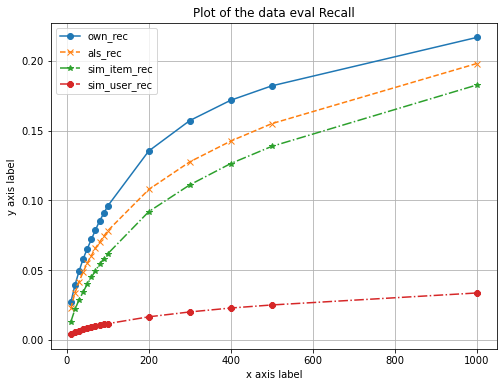

In [77]:
list_n = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000]
xticks = [0.01*i for i in range(1,10)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(list_n, result_own_rec, "o-")
ax.plot(list_n, result_als_rec, "x--")
ax.plot(list_n, result_sim_item_rec, "*-.")
ax.plot(list_n, result_sim_user_rec, "8-.")
ax.grid()
ax.set_title("Plot of the data eval Recall")
ax.set_xlabel("x axis label")
ax.set_ylabel("y axis label")
ax.legend(("own_rec", "als_rec", "sim_item_rec", "sim_user_rec"))

In [78]:
def progress(res_list):
    res = []
    for i, el in enumerate(res_list):
        if i != 0:
            progr = round(((el - prev_el) / prev_el) * 100, 1)
            res.append(progr)
        prev_el = el
    return res  

In [79]:
progress(result_own_rec)

[46.1, 25.2, 18.1, 12.4, 10.3, 9.4, 8.1, 6.3, 6.0, 41.0, 16.1, 9.3, 6.0, 19.1]

In [80]:
result_eval_matcher['own_rec_45'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, 45))
result_eval_matcher['als_rec_5'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, 5))
result_eval_matcher['own_rec_45_+_als_rec_5'] = result_eval_matcher['own_rec_45'] + result_eval_matcher['als_rec_5']

In [81]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_45_+_als_rec_5'], row[ACTUAL_COL], k=50), axis=1).mean()

0.06647381915594787

In [82]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_50'], row[ACTUAL_COL], k=50), axis=1).mean()

0.06525657038145175

In [83]:
# result_eval_matcher['als_rec_50'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, 50))

result_eval_matcher.apply(lambda row: recall_at_k(row['als_rec_50'], row[ACTUAL_COL], k=50), axis=1).mean()

0.05501969881676552

Вариант own recommendtions + top-popular не дает лучший вариант, но обгоняет второй место, уступая немного первому месту - чистому варианту own_recommendtions.

In [84]:
evalRecall(result_eval_matcher, 'als_rec', USER_COL, recommender.get_als_recommendations, N_PREDICT)

0.05501969881676552

In [85]:
evalRecall(result_eval_matcher, 'own_rec', USER_COL, recommender.get_own_recommendations, N_PREDICT)

0.06525657038145175

In [86]:
evalRecall(result_eval_matcher, 'sim_item_rec', USER_COL, recommender.get_similar_items_recommendation, N_PREDICT)

0.03997471015641097

In [87]:
evalRecall(result_eval_matcher, 'sim_user_rec', USER_COL, recommender.get_similar_users_recommendation, N_PREDICT)

0.00835369415586707

In [88]:
import itertools

In [89]:
drop_columns_num = [10, 20, 30, 40, 60, 70, 80, 90, 100, 200, 300, 400, 1000]
drop_columns_name = ['own_rec_', 'als_rec_', 'sim_item_rec_', 'sim_user_rec_']
for el in list(itertools.product(drop_columns_name, drop_columns_num, repeat=1)):
    result_eval_matcher.drop(columns = [str(el[0])+str(el[1])], axis = 1, inplace=True)

In [90]:
result_eval_matcher

,user_id,actual,result,own_rec_50,own_rec_500,als_rec_50,als_rec_500,sim_item_rec_50,sim_item_rec_500,sim_user_rec_50,sim_user_rec_500,own_rec_45,als_rec_5,own_rec_45_+_als_rec_5,als_rec,own_rec,sim_item_rec,sim_user_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1090676, 995598, 1047619, 856942, 5577022, 10...","[1090676, 995598, 1047619, 856942, 5577022, 10...","[912704, 1007512, 9297615, 5577022, 9670830, 9...","[912704, 1007512, 9297615, 5577022, 9670830, 9...","[6391080, 948640, 5564850, 6552318, 917406, 98...","[6391080, 948640, 5564850, 6552318, 917406, 98...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1090676, 995598, 1047619, 856942, 5577022]","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1090676, 995598, 1047619, 856942, 5577022, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[912704, 1007512, 9297615, 5577022, 9670830, 9...","[6391080, 948640, 5564850, 6552318, 917406, 98..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 978332, 1104414, 1021324, 1056620, 8...","[5569230, 978332, 1104414, 1021324, 1056620, 8...","[8090537, 1044078, 5569845, 985999, 819978, 88...","[8090537, 1044078, 5569845, 985999, 819978, 88...","[961889, 841287, 833241, 7410321, 1103808, 112...","[961889, 841287, 833241, 7410321, 1103808, 112...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 978332, 1104414, 1021324, 1056620]","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 978332, 1104414, 1021324, 1056620, 8...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 1044078, 5569845, 985999, 819978, 88...","[961889, 841287, 833241, 7410321, 1103808, 112..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 891423, 1137010, 936470, 1075368, 96...","[6391541, 891423, 1137010, 936470, 1075368, 96...","[1090507, 846550, 960075, 7025250, 999714, 108...","[1090507, 846550, 960075, 7025250, 999714, 108...","[1094190, 1039360, 973016, 825118, 1122844, 74...","[1094190, 1039360, 973016, 825118, 1122844, 74...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 891423, 1137010, 936470, 1075368]","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 891423, 1137010, 936470, 1075368, 96...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1090507, 846550, 960075, 7025250, 999714, 108...","[1094190, 1039360, 973016, 825118, 1122844, 74..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 972416, 995598, 923600, 1138596, 10...","[13003092, 972416, 995598, 923600, 1138596, 10...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1026118, 965267, 871611, 896613, 1127179, 108...","[1026118, 965267, 871611, 896613, 1127179, 108...","[948650, 5569845, 934639, 941361, 893018, 1105...","[948650, 5569845, 934639, 941361, 893018, 1105...","[893362, 948640, 1075796, 867138, 1015280, 697...","[893362, 948640, 1075796, 867138, 1015280, 697...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1026118, 965267, 871611, 896613, 1127179]","[13003092, 972416, 995598, 923600, 1138596, 10...","[1026118, 965267, 871611, 896613, 1127179, 108...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 934639, 941361, 893018, 1105...","[893362, 948640, 1075796, 867138, 1015280, 697..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[998519, 894360, 7147142, 9338009, 896666, 939...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1100140, 10285022, 1118547, 1056973, 

### Recall@50 of matching

In [91]:
TOPK_RECALL = 50

In [92]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec_45_+_als_rec_5', 0.06647381915594787),
 ('own_rec_50', 0.06525657038145175),
 ('own_rec_500', 0.06525657038145175),
 ('own_rec', 0.06525657038145175),
 ('own_rec_45', 0.06212243669915392),
 ('als_rec_50', 0.05501969881676552),
 ('als_rec_500', 0.05501969881676552),
 ('als_rec', 0.05501969881676552),
 ('result', 0.044119547395835505),
 ('sim_item_rec_50', 0.03997471015641097),
 ('sim_item_rec_500', 0.03997471015641097),
 ('sim_item_rec', 0.03997471015641097),
 ('als_rec_5', 0.014726172376516343),
 ('sim_user_rec_50', 0.00835369415586707),
 ('sim_user_rec_500', 0.00835369415586707),
 ('sim_user_rec', 0.00835369415586707)]

### Precision@5 of matching

In [93]:
TOPK_PRECISION = 5

In [94]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('result', 0.17712691771268974),
 ('own_rec_50', 0.17712691771268974),
 ('own_rec_500', 0.17712691771268974),
 ('own_rec_45', 0.17712691771268974),
 ('own_rec_45_+_als_rec_5', 0.17712691771268974),
 ('own_rec', 0.17712691771268974),
 ('als_rec_50', 0.13035797303579597),
 ('als_rec_500', 0.13035797303579597),
 ('als_rec_5', 0.13035797303579597),
 ('als_rec', 0.13035797303579597),
 ('sim_item_rec_50', 0.0697350069735009),
 ('sim_item_rec_500', 0.0697350069735009),
 ('sim_item_rec', 0.0697350069735009),
 ('sim_user_rec_50', 0.016085541608554143),
 ('sim_user_rec_500', 0.016085541608554143),
 ('sim_user_rec', 0.016085541608554143)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [364]:
# 3 временных интервала
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [95]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [96]:
df_match_candidates

,user_id
0,2375
1,1364
2,1130
3,1173
4,98
...,...
2146,540
2147,338
2148,615
2149,1077


In [97]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [98]:
df_match_candidates.head(2)

,user_id,candidates
0,2375,"[948640, 918046, 847962, 907099, 873980, 88469..."
1,1364,"[1101378, 8090570, 857176, 947013, 1065979, 10..."


In [99]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items

0        948640
0        918046
0        847962
0        907099
0        873980
         ...   
2150     909714
2150     995478
2150    1075214
2150    1138443
2150    1023720
Length: 107550, dtype: int64

In [100]:
df_items.name = 'item_id'
df_items

0        948640
0        918046
0        847962
0        907099
0        873980
         ...   
2150     909714
2150     995478
2150    1075214
2150    1138443
2150    1023720
Name: item_id, Length: 107550, dtype: int64

In [101]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [102]:
df_match_candidates.head(4)

,user_id,item_id
0,2375,948640
0,2375,918046
0,2375,847962
0,2375,907099


### Check warm start

In [103]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [374]:
# df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
# df_ranker_train['target'] = 1  # тут только покупки 

In [104]:
df_ranker_train = data_train_ranker.copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [105]:
df_ranker_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,avr_trans_time,time_cat,num_of_purchases,num_week_no,total_amount_of_purchases,avr_purchase_receipt,avr_weekly_purchase_receipt,num_days,avr_num_of_purchases_per_day,target
563,2375,40630425577,594,835300,1,4.73,364,0.00,1305,86,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,1
564,2375,40630425577,594,848029,1,11.21,364,-4.50,1305,86,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,1
565,2375,40630425577,594,862714,3,2.37,364,-0.60,1305,86,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,1
566,2375,40630425577,594,896613,2,6.24,364,-2.71,1305,86,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,1
567,2375,40630425577,594,923746,1,1.49,364,0.00,1305,86,...,1237,day,105,51,2486.42,23.68019,48.753333,659,0.159332,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [106]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

(!) На каждого юзера 50 item_id-кандидатов

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

In [107]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [108]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_19-24,age_25-34,...,Unknown,household_size_1,household_size_2,household_size_3,household_size_4,household_size_5+,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,0,1,0,0,0,0,0,0,1


In [109]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,Unknown,household_size_1,household_size_2,household_size_3,household_size_4,household_size_5+,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown
0,2375,948640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,918046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [110]:
df_ranker_train.head()

,user_id,item_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,Unknown,household_size_1,household_size_2,household_size_3,household_size_4,household_size_5+,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown
0,2375,948640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,918046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2375,847962,4.076522e+10,605.0,1.0,2.99,391.0,0.0,609.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2375,907099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2375,873980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [112]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['basket_id',
 'day',
 'quantity',
 'sales_value',
 'store_id',
 'retail_disc',
 'trans_time',
 'week_no',
 'coupon_disc',
 'coupon_match_disc',
 'avr_trans_time',
 'time_cat',
 'num_of_purchases',
 'num_week_no',
 'total_amount_of_purchases',
 'avr_purchase_receipt',
 'avr_weekly_purchase_receipt',
 'num_days',
 'avr_num_of_purchases_per_day',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'age_19-24',
 'age_25-34',
 'age_35-44',
 'age_45-54',
 'age_55-64',
 'age_65+',
 'status_A',
 'status_B',
 'status_U',
 'income_100-124K',
 'income_125-149K',
 'income_15-24K',
 'income_150-174K',
 'income_175-199K',
 'income_200-249K',
 'income_25-34K',
 'income_250K+',
 'income_35-49K',
 'income_50-74K',
 'income_75-99K',
 'income_Under 15K',
 'homeowner_Homeowner',
 'homeowner_Probable Owner',
 'homeo

## Обучение модели ранжирования

In [113]:
from catboost import CatBoost, Pool

In [51]:
# делали на вебинаре, кусок с катбустом


# df_bin_feat = pd.get_dummies(X_train)

# model = CatBoost(params ={'objective': "Logloss",
#                           "iterations":1000,
#                           "max_depth":8,
#                           "task_type":"GPU",
#                           "devices":"0:1:2:3"
#             })
# model.fit(df_bin_juice, y_train, silent=True)

# train_preds = model.predict(df_bin_feat,prediction_type="Probability")

In [185]:
lgb = LGBMClassifier(objective='binary',
                     boosting_type='gbdt',
                     max_depth=55,
                     num_leaves=20,
                     min_child_samples=12,
                     n_estimators=600,
#                      learning_rate=0.327855,
                     learning_rate=0.042785714285714285,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

J:\Vadim\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
J:\Vadim\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
J:\Vadim\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [186]:
df_ranker_predict = df_ranker_train.copy()

In [187]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [188]:
df_ranker_predict['proba_item_purchase'][:10]

0    1.495548e-06
1    9.350492e-07
2    9.999830e-01
3    1.103113e-06
4    9.655672e-07
5    9.655672e-07
6    9.212595e-07
7    1.540097e-06
8    1.092764e-06
9    1.102180e-06
Name: proba_item_purchase, dtype: float64

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [137]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [138]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: total: 219 ms
Wall time: 222 ms


In [139]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значит и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
 

In [140]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [189]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [190]:
tuple_res = sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)[0]

C:\Users\Вадим\Desktop\GeekBrains\Recommendation-systems\Homework\Lesson_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


In [191]:
tuple_res[0]

'reranked_own_rec'

In [192]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1872584856396853)
('own_rec', 0.1444117647058813)


C:\Users\Вадим\Desktop\GeekBrains\Recommendation-systems\Homework\Lesson_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера